In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from copy import deepcopy

In [135]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 5000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [136]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

In [137]:
def action_from_uniform_dist(action_space):
    ''' Select an action from a uniform distribution 
    Args:
    - action_space (int): Number of actions in the action space of environment
    
    Return:
    - (int): Action sampled from uniform distribution
    - (int): Probability of action being sampled
    
    '''
    
    #uniform distribution of all actions in environment
    dist = torch.Tensor(np.full(action_space, 1/action_space)).to(DEVICE)
    
    #sample action
    m = Categorical(dist)
    action = m.sample()

    #return action and probability
    return action.item(), dist[action.item()].item()

In [138]:
def get_log_prob(network, state, action):
    ''' Get log probability of an action given state
    Args:
    - network (Pytorch model): Model used to get probability
    - state (Array): Current state of environment
    - action (int): Action to be taken at this step
    
    Return:
    - (Tensor): log probability of action under given network
    
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state_tensor)
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    
    #return action log probability
    return m.log_prob(torch.Tensor([action]).to(DEVICE))
    

In [139]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [158]:
#Make training environment and evaluation environment
env = gym.make('CartPole-v1').env
env2 = deepcopy(env)

#Init policy network
network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=1e-2)

In [159]:
#track scores
scores = []
policy_scores = []

#iterate through episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state = env.reset()
    state2 = env2.reset()
    
    done = False
    done2 = False
    
    rewards = []
    log_probs = []
    imp_weights = []
    
    score = 0
    score2 = 0
    
    #generate episode
    for step in range(MAX_STEPS):
        #env.render()
        
        #select action
        action, b_prob = action_from_uniform_dist(env.action_space.n)
        
        #get log probability of action
        lp = get_log_prob(network, state, action)
        
        #get importance weight
        iw = torch.exp(lp).item() / b_prob
        
        #execute action        
        new_state, reward, done, _ = env.step(action)
        
        #track episode score
        score += reward
        
        #store reward, log probability, importance weights
        rewards.append(reward)
        log_probs.append(lp)
        imp_weights.append(iw)
        
        #end episode if done
        if done:
            break
        
        #move into new state
        state = new_state
        
    for step in range(MAX_STEPS):
        #env2.render()
        
        action2, _ = select_action(network, state2)
        new_state2, reward2, done2, _ = env2.step(action2)
        
        score2 += reward2
        
        if done2:
            break
            
        state2 = new_state2
        
    
    #append score
    scores.append(score)
    policy_scores.append(score2)
        
    #Calculate Gt (cumulative discounted rewards)
    G = []
    
    #track cumulative reward
    total_r = 0
    
    #iterate rewards from Gt to G0
    for r in reversed(rewards):
        
        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r * DISCOUNT_FACTOR
        
        #append to discounted rewards
        G.insert(0, total_r)
    
    #whitening rewards
    G = torch.tensor(G).to(DEVICE)
    G = (G - G.mean())/G.std()
    
    #adjusting policy parameters with gradient ascent
    loss = []
    for r, lp, iw in zip(G, log_probs, imp_weights):
        #we add a negative sign since network will perform gradient descent and we are doing gradient ascent with policy parameters
        loss.append(-r * lp * iw)
    
        
    #Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    optimizer.step()

env.close()

#### Plotting training score:

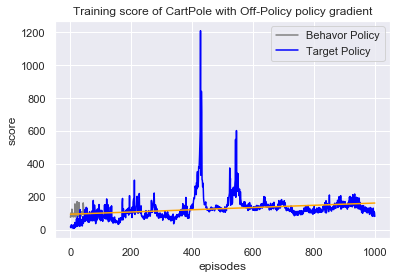

In [163]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores, color='grey', label='Behavor Policy')
plt.plot(policy_scores, color='blue', label='Target Policy')
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with Off-Policy policy gradient')
plt.legend()

reg = LinearRegression().fit(np.arange(len(policy_scores)).reshape(-1, 1), np.array(policy_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(policy_scores)).reshape(-1, 1))
plt.plot(y_pred, color='orange')
plt.show()

#### Random Policy:

In [82]:
done = False
state = env.reset()
scores = []

for _ in range(50):
    state = env.reset()
    done = False
    score = 0
    while not done:
        #env.render()
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

#### Trying Policy:

In [160]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    for _ in range(MAX_STEPS):
        #env.render()
        action, lp = select_action(network, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        
        if done:
            break
        
        state = new_state
    scores.append(score)
env.close()

In [46]:
env.close()

In [161]:
np.array(scores).mean()

100.44